In [1]:
import time
import os

import scanpy
import numpy as np
import scipy.sparse as sp

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gc
from skimage import io
import umap
from sklearn.cluster import MiniBatchKMeans,AgglomerativeClustering
from sklearn.decomposition import PCA
from util.plot_new import plotembeddingbyCT,plotembeddingbyCT_contrast
import cv2
import sklearn.metrics 

from util.plot_new import *

In [ ]:
anno=pd.read_csv('/media/xinyi/dcis2idc/data/Supplementary Table 1_v1.csv')

In [85]:
imaged=np.sum(anno.to_numpy()[:,-4:],axis=1)

In [87]:
np.unique(anno['patient_id'][imaged>0]).size

122

In [2]:
radius=48
datadir='/media/xinyi/dcis2idc1/data'
with open(os.path.join(datadir,'processed','train_cnnvae_names'), 'rb') as input:
    allImgNames=pickle.load(input)
name='exp0'
plotsavepath='/media/xinyi/dcis2idc1/plots/cnnvae'+name
modelsavepath='/media/xinyi/dcis2idc1/models/cnnvae'+name
plottype='umap'
sampledir=plotsavepath
savedir=os.path.join(sampledir,'embedding_'+plottype+'_reordered')
clustersavedir=os.path.join(sampledir,'cluster_reordered')
clustersavedir_old=os.path.join(sampledir,'cluster')

In [3]:
with open(os.path.join(datadir,'processed','train_cnnvae_coord'), 'rb') as output:
    coordlist=pickle.load(output)

In [4]:
with open(os.path.join(datadir,'processed','train_cnnvae_cellLabels'), 'rb') as output:
    cellIDlist=pickle.load(output)

In [25]:
def plotCTcomp_hist(labels,ctlist,savepath,savenamecluster,byCT,addname=''):
    res=np.zeros((np.unique(labels).size,np.unique(ctlist).size))
    for li in range(res.shape[0]):
        l=np.unique(labels)[li]
        nl=np.sum(labels==l)
        ctlist_l=ctlist[labels==l]
        for ci in range(res.shape[1]):
            c=np.unique(ctlist)[ci]
            res[li,ci]=np.sum(ctlist_l==c)
#             res[li,ci]=np.sum(ctlist_l==c)/nl
    if not byCT:
        addname+=''
        for li in range(res.shape[0]):
            l=np.unique(labels)[li]
            nl=np.sum(labels==l)
            res[li]=res[li]/nl
    else:
        addname+='_normbyCT'
        for ci in range(res.shape[1]):
            c=np.unique(ctlist)[ci]
            nc=np.sum(ctlist==c)
            res[:,ci]=res[:,ci]/nc
    
    fig, ax = plt.subplots(nrows=res.shape[0], ncols=1,figsize=(10, 10),sharex=True,sharey=True)
    for r in range(res.shape[0]):
        ax[r].bar(np.arange(res.shape[1]),res[r])
        ax[r].set_xticks(np.arange(np.unique(ctlist).size))
        ax[r].set_xticklabels(np.unique(ctlist))
        ax[r].set_ylim(0,1)
        ax[r].set_ylabel(np.unique(labels)[r])
        
#         ax.set_yticks(np.arange(np.unique(labels).size))
#         ax.set_yticklabels(np.unique(labels))
#         ax.set_xticks(np.arange(np.unique(ctlist).size))
#         ax.set_xticklabels(np.unique(ctlist))
#         plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    fig.tight_layout()
    plt.savefig(os.path.join(savepath,savenamecluster+addname+'.jpg'))
    plt.close()

In [26]:
def plotCTcomp_hist_cont(labels,ctlist,samplelist,savepath,savenamecluster,addname=''):
    
    fig, ax = plt.subplots(nrows=np.unique(labels).size, ncols=1,figsize=(10, 10),sharex=True,sharey=True)
    for r in range(np.unique(labels).size):
        counts=[]
        for s in np.unique(samplelist[labels==np.unique(labels)[r]]):
            sridx=np.logical_and(labels==np.unique(labels)[r],samplelist==s)
            counts.append(np.sum(ctlist[sridx])/np.sum(sridx))
        ax[r].hist(counts,bins=10,range=(0,1))
        ax[r].set_ylabel(np.unique(labels)[r])
        
#         ax.set_yticks(np.arange(np.unique(labels).size))
#         ax.set_yticklabels(np.unique(labels))
#         ax.set_xticks(np.arange(np.unique(ctlist).size))
#         ax.set_xticklabels(np.unique(ctlist))
#         plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    fig.tight_layout()
    plt.savefig(os.path.join(savepath,savenamecluster+addname+'.jpg'))
    plt.close()

In [27]:
def getHistMatrix(labels,ctlist):
    res=np.zeros((np.unique(labels).size,np.unique(ctlist).size))
    for li in range(res.shape[0]):
        l=np.unique(labels)[li]
        nl=np.sum(labels==l)
        ctlist_l=ctlist[labels==l]
        for ci in range(res.shape[1]):
            c=np.unique(ctlist)[ci]
            res[li,ci]=np.sum(ctlist_l==c)
#             res[li,ci]=np.sum(ctlist_l==c)/nl
        res[li]=res[li]/nl
    return res

def getHistMatrix_clusters(labels,ctlist,nrow=8,ncol=8):
    res=np.zeros((nrow,ncol))
    for li in range(res.shape[0]):
        l=li
        nl=np.sum(labels==l)
        ctlist_l=ctlist[labels==l]
        for ci in range(res.shape[1]):
            c=ci
            res[l,c]=np.sum(ctlist_l==c)
#             res[li,ci]=np.sum(ctlist_l==c)/nl
        if nl!=0:
            res[li]=res[li]/nl
    return res

def plotCTcomp_hist_withRandom(labels,ctlist,sampledlabels,sampledctlist,savepath,savenamecluster,savenamestats,addname='',distMeasure=['euclidean','tv']):
    res=getHistMatrix(labels,ctlist)    
    nRandomsamples=sampledlabels.shape[0]
    resRandom=np.zeros((nRandomsamples,res.shape[0],res.shape[1]))
    print(sampledlabels.shape)
    print(sampledctlist.shape)
    for rand in range(nRandomsamples):
        resRandom[rand]=getHistMatrix(sampledlabels[rand],sampledctlist[rand])
    resRandomMean=np.mean(resRandom,axis=0,keepdims=True)
    resRandomStd=np.std(resRandom,axis=0,keepdims=True)
    
    fig, ax = plt.subplots(nrows=res.shape[0], ncols=1,figsize=(10, 10),sharex=True,sharey=True)
    for r in range(res.shape[0]):
        ax[r].bar(np.arange(res.shape[1])-0.2,res[r],0.4,label='observed')
        ax[r].bar(np.arange(res.shape[1])+0.2,resRandomMean[0,r],0.4,label='random',yerr=resRandomStd[0,r],capsize=2,ecolor='red')
        ax[r].set_xticks(np.arange(np.unique(ctlist).size))
        ax[r].set_xticklabels(np.unique(ctlist))
        ax[r].set_ylim(0,1)
        ax[r].set_ylabel(np.unique(labels)[r])
        ax[r].legend()
#         ax.set_yticks(np.arange(np.unique(labels).size))
#         ax.set_yticklabels(np.unique(labels))
#         ax.set_xticks(np.arange(np.unique(ctlist).size))
#         ax.set_xticklabels(np.unique(ctlist))
#         plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    fig.tight_layout()
    plt.savefig(os.path.join(savepath,savenamecluster+addname+'.jpg'))
    plt.close()
    
    #compute significance
    significanceRes=pd.DataFrame(np.zeros((np.unique(labels).size,len(distMeasure))),index=np.unique(labels),columns=distMeasure)
    for c in range(len(distMeasure)):
        dist_c=distMeasure[c]
        if dist_c=='euclidean':
            distRand=np.linalg.norm(resRandom-resRandomMean,ord=2,axis=2)
            distTrue=np.linalg.norm(res-resRandomMean[0],ord=2,axis=1).reshape((1,-1))
            distCompare=np.greater(distRand,distTrue)
            distCompare=np.sum(distCompare,axis=0)
            significanceRes['euclidean']=(distCompare+1)/(nRandomsamples+1)            
        if dist_c=='tv': #omitting 1/2 since results do not change
            distRand=np.linalg.norm(resRandom-resRandomMean,ord=1,axis=2)
            distTrue=np.linalg.norm(res-resRandomMean[0],ord=1,axis=1).reshape((1,-1))
            distCompare=np.greater(distRand,distTrue)
            distCompare=np.sum(distCompare,axis=0)
            significanceRes['tv']=(distCompare+1)/(nRandomsamples+1)
    significanceRes.to_csv(os.path.join(savepath,savenamecluster+addname+'_significance.csv'))
    #calculate individual p-values
    distRand=np.abs(resRandom-resRandomMean)
    distTrue=np.abs(res-resRandomMean[0]).reshape((1,res.shape[0],res.shape[1]))
    distCompare=np.greater(distRand,distTrue)
    distCompare=(np.sum(distCompare,axis=0)+1)/(nRandomsamples+1)
    np.savetxt(os.path.join(savepath,savenamecluster+addname+'_significanceSeparated.csv'),distCompare)
#     return significanceRes,distCompare


In [28]:
def plotCTcomp_hist_withRandom_bonferroni(labels,ctlist,sampledlabels,sampledctlist,savepath,savenamecluster,savenamestats,addname='',distMeasure=['euclidean','tv']):
    res=getHistMatrix(labels,ctlist)    
#     actualSamples=sampledlabels.shape[0]
    resRandom=np.zeros((actualSamples,res.shape[0],res.shape[1]))
#     print(sampledlabels.shape)
#     print(sampledctlist.shape)
    rand=0
    for imgNidx in range(len(sampledlabels)):
        for randIdx in range(sampledlabels[imgNidx].shape[0]):
            resRandom[rand]=getHistMatrix(sampledlabels[imgNidx][randIdx],sampledctlist[imgNidx][randIdx])
            rand+=1
    print(np.sum(np.sum(resRandom,axis=(1,2))==0))
    resRandomMean=np.mean(resRandom,axis=0,keepdims=True)
    resRandomStd=np.std(resRandom,axis=0,keepdims=True)
    
    
    #compute significance
    significanceRes=pd.DataFrame(np.zeros((np.unique(labels).size,len(distMeasure))),index=np.unique(labels),columns=distMeasure)
    for c in range(len(distMeasure)):
        dist_c=distMeasure[c]
        if dist_c=='euclidean':
            distRand=np.linalg.norm(resRandom-resRandomMean,ord=2,axis=2)
            distTrue=np.linalg.norm(res-resRandomMean[0],ord=2,axis=1).reshape((1,-1))
            distCompare=np.greater(distRand,distTrue)
            distCompare=np.sum(distCompare,axis=0)
            significanceRes['euclidean']=(distCompare+1)/(actualSamples+1)            
        if dist_c=='tv': #omitting 1/2 since results do not change
            distRand=np.linalg.norm(resRandom-resRandomMean,ord=1,axis=2)
            distTrue=np.linalg.norm(res-resRandomMean[0],ord=1,axis=1).reshape((1,-1))
            distCompare=np.greater(distRand,distTrue)
            distCompare=np.sum(distCompare,axis=0)
            significanceRes['tv']=(distCompare+1)/(actualSamples+1)
    significanceRes.to_csv(os.path.join(savepath,savenamecluster+addname+'_significance.csv'))
    #calculate individual p-values
    distRand=np.abs(resRandom-resRandomMean)
    distTrue=np.abs(res-resRandomMean[0]).reshape((1,res.shape[0],res.shape[1]))
    distCompare=np.greater(distRand,distTrue)
    distCompare=(np.sum(distCompare,axis=0)+1)/(actualSamples+1)
    np.savetxt(os.path.join(savepath,savenamecluster+addname+'_significanceSeparated.csv'),distCompare)
    np.savetxt(os.path.join(savepath,savenamecluster+addname+'_resRandomMean.csv'),resRandomMean[0])
    np.savetxt(os.path.join(savepath,savenamecluster+addname+'_res.csv'),res)
    #plot later for same scales across pathologies
#     res_plot=np.zeros((res.shape[0],res.shape[0]),figsize=(10,10))
#     res_plot=res/resRandomMean[0]
    



## cluster vs pathology

In [5]:
#plot by disease progression
br1003aSpecs=pd.read_excel('/media/xinyi/dcis2idc1/data/BR1003a specs.xlsx',header=10)
br301Specs=pd.read_excel('/media/xinyi/dcis2idc1/data/BR301 specs.xlsx',header=10)
br8018aSpecs=pd.read_excel('/media/xinyi/dcis2idc1/data/BR8018a specs.xlsx',header=10)
br1003aSpecs.index=br1003aSpecs.loc[:,'Position']
br301Specs.index=br301Specs.loc[:,'Position']
br8018aSpecs.index=br8018aSpecs.loc[:,'Position']

progList=np.copy(allImgNames)
for s in np.unique(allImgNames):
    ssplit=s.split('_')
    if 'br1003a'==ssplit[0]:
        prog_s=br1003aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br301'==ssplit[0]:
        prog_s=br301Specs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br8018a'==ssplit[0]:
        prog_s=br8018aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    progList[allImgNames==s]=prog_s

In [91]:
np.min(progCounts)

24224

In [6]:
progNames,progCounts=np.unique(progList,return_counts=True)
progSampleRate={}
for p in range(progNames.size):
    progSampleRate[progNames[p]]=np.min(progCounts)/progCounts[p]
    
plotepoch=311
np.random.seed(6)
plottingIdx_i=np.array([])
n_pcs=50
uniqueImgNames,imgNameIdx=np.unique(allImgNames,return_index=True)
for i in range(1):
    for sidx in range(uniqueImgNames.size):
        s=uniqueImgNames[sidx]
        p=progList[imgNameIdx[sidx]]
        print(s+' '+p)
        nsamples=int(np.sum(allImgNames==s)*progSampleRate[p])
        plottingIdx_i=np.concatenate((plottingIdx_i,
                                    np.random.choice(np.arange(allImgNames.shape[0])[allImgNames==s],nsamples,replace=False)))





br1003a_1_cytokeratin_555_aSMA_647_hoechst_A1 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A2 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A4 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A5 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A6 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A7 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A8 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A9 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C1 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C10 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C2 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C3 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C4 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C5 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C6 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C7 Hyperplasia
br1003a_1_cytokeratin_555_

br301_6_collagen1_647_hoechst_D2 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_D3 Invasive ductal carcinoma and breast tissue
br301_6_collagen1_647_hoechst_D4 Invasive ductal carcinoma
br301_6_collagen1_647_hoechst_D5 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_D6 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_E1 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_E2 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_E3 Invasive ductal carcinoma and breast tissue
br301_6_collagen1_647_hoechst_E4 Invasive ductal carcinoma
br301_6_collagen1_647_hoechst_E5 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_E6 Ductal carcinoma in situ with early infiltratio
br8018a_1_cytokeratin_555_aSMA_647_hoechst_A1 Invasive ductal carcinoma
br8018a_1_cytokeratin_555_aSMA_647_hoechst_A10 Invasive ductal carcinoma
br8018a_1_cytoke

In [7]:
plotsavenameAdd='_plottingIdx_progBalanced_'+str(i)+'_reordered'

In [8]:
np.unique(progList[plottingIdx_i.astype(int)])

array(['Atypical hyperplasia', 'Breast tissue',
       'Cancer adjacent normal breast tissue', 'Ductal carcinoma in situ',
       'Ductal carcinoma in situ and breast tissue',
       'Ductal carcinoma in situ with early infiltratio', 'Hyperplasia',
       'Invasive ductal carcinoma',
       'Invasive ductal carcinoma (breast tissue)',
       'Invasive ductal carcinoma and breast tissue',
       'Micropapillary type ductal carcinoma in situ wi'], dtype='<U47')

In [9]:
progList_comb=np.copy(progList)
for p in np.unique(progList):
    if p=='Ductal carcinoma in situ':
        progList_comb[progList==p]='DCIS and breast tissue'
        progList[progList==p]='DCIS'
    elif p=='Ductal carcinoma in situ and breast tissue':
        progList_comb[progList==p]='DCIS and breast tissue'
        progList[progList==p]='DCIS and breast tissue'
    elif p=='Ductal carcinoma in situ with early infiltratio':
        progList_comb[progList==p]='DCIS with early infiltration'
        progList[progList==p]='DCIS with early infiltration'
    elif p=='Micropapillary type ductal carcinoma in situ wi':
        progList_comb[progList==p]='DCIS with early infiltration'
        progList[progList==p]='Micropapillary DCIS with early infiltration'
    elif p=='Atypical hyperlasia':
        progList_comb[progList==p]='Hyperplasia'

In [10]:
ctorder=np.array(['Breast tissue','Cancer adjacent normal breast tissue','Invasive ductal carcinoma (breast tissue)','Hyperplasia','Atypical hyperplasia','DCIS and breast tissue','DCIS','DCIS with early infiltration', 'Micropapillary DCIS with early infiltration','Invasive ductal carcinoma and breast tissue','Invasive ductal carcinoma'])
nclusterL=[8]
for ncluster in nclusterL:
    savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+plotsavenameAdd
    with open(os.path.join(clustersavedir_old,savenamecluster), 'rb') as output:
        clusterRes=pickle.load(output)
    clusterplotsavepath=os.path.join(clustersavedir,savenamecluster+'_plots')
    if not os.path.exists(clusterplotsavepath):
        os.mkdir(clusterplotsavepath)
    plotCTcomp(clusterRes,progList[plottingIdx_i.astype(int)],clusterplotsavepath,'pathologyHeatmap_rename',False,ctorder=ctorder,vmin=0)
    plotCTcomp(clusterRes,progList[plottingIdx_i.astype(int)],clusterplotsavepath,'pathologyHeatmap_rename',True,ctorder=ctorder,vmin=0)

In [11]:
#add colorbar; add histogram; add combined pathology
ctorder_rename=np.array(['Breast tissue','Cancer adjacent normal breast tissue','Hyperplasia','DCIS and breast tissue','DCIS with early infiltration', 'Invasive ductal carcinoma and breast tissue','Invasive ductal carcinoma'])
nclusterL=[8]
for ncluster in nclusterL:
    savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+plotsavenameAdd
    with open(os.path.join(clustersavedir_old,savenamecluster), 'rb') as output:
        clusterRes=pickle.load(output)
    clusterplotsavepath=os.path.join(clustersavedir,savenamecluster+'_plots')
    if not os.path.exists(clusterplotsavepath):
        os.mkdir(clusterplotsavepath)
    plotCTcomp(clusterRes,progList_comb[plottingIdx_i.astype(int)],clusterplotsavepath,'pathologyHeatmap_renameComb',False,ctorder=ctorder_rename,vmin=0)
    plotCTcomp(clusterRes,progList_comb[plottingIdx_i.astype(int)],clusterplotsavepath,'pathologyHeatmap_renameComb',True,ctorder=ctorder_rename,vmin=0)

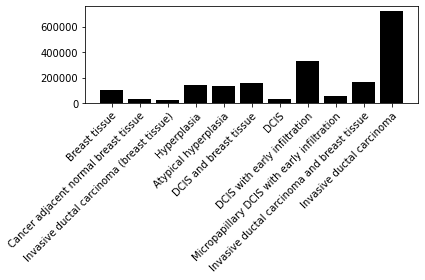

In [35]:
progNames,progCounts=np.unique(progList,return_counts=True)
progCounts_order=np.array([])
for p in ctorder:
    progCounts_order=np.concatenate((progCounts_order,progCounts[progNames==p]))
fig, ax = plt.subplots()
ax.bar(ctorder,progCounts_order,color='black')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
plt.tight_layout()
plt.savefig(os.path.join(clusterplotsavepath,'pathologyHist.pdf'))

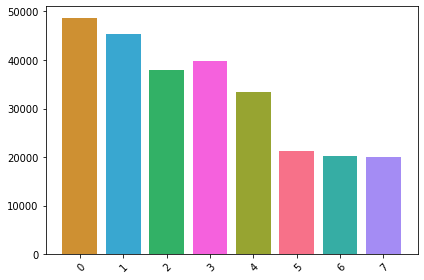

In [51]:
clusterNames,clusterCounts=np.unique(clusterRes,return_counts=True)
fig, ax = plt.subplots()
neworder=np.array([1, 5, 3, 7, 2, 0, 4, 6]).astype(int)
ax.bar(clusterNames,clusterCounts,color=np.array(sns.color_palette("husl",8))[neworder])
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
plt.tight_layout()
plt.savefig(os.path.join(clusterplotsavepath,'clusterHist.pdf'))

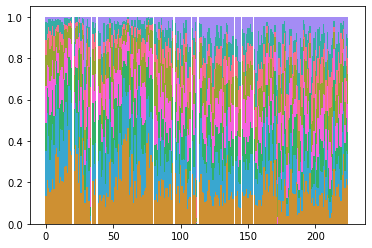

In [62]:
sUnique,sidx_start=np.unique(allImgNames[plottingIdx_i.astype(int)],return_index=True)

#get cluster composition
clusterUnique=np.unique(clusterRes)
inputCluster=np.zeros((sUnique.size,clusterUnique.size))
for i in range(sUnique.size):
    clusterRes_i=clusterRes[allImgNames[plottingIdx_i.astype(int)]==sUnique[i]]
    for j in range(clusterUnique.size):
        inputCluster[i,j]=np.sum(clusterRes_i==clusterUnique[j])
inputCluster=inputCluster/np.sum(inputCluster,axis=1,keepdims=True)

inputCluster_orderedP=np.zeros((sUnique.size+ctorder.size,clusterUnique.size))
progList_orderedP=np.array([])
currIdx=0
for p in ctorder:
    coreIdx=progList[plottingIdx_i.astype(int)][sidx_start]==p
    inputCluster_orderedP[currIdx:(currIdx+np.sum(coreIdx))]=inputCluster[coreIdx]
    progList_orderedP=np.concatenate((progList_orderedP,np.repeat(p,np.sum(coreIdx))))
    currIdx+=np.sum(coreIdx)+1
    
fig, ax = plt.subplots()
bottom=np.zeros(inputCluster_orderedP.shape[0])
for c in clusterUnique:
    ax.bar(np.arange(inputCluster_orderedP.shape[0]),inputCluster_orderedP[:,c],bottom=bottom,color=np.array(sns.color_palette("husl",8))[neworder[c]],width=1)
    bottom+=inputCluster_orderedP[:,c]
plt.savefig(os.path.join(clusterplotsavepath,'cluster_cores.pdf'))

## cluster vs proteins

### heatmap

In [10]:
stats2plot=['int_median','kurtosis','skewness','int_mode','entropy']
stains=['aSMA','cytokeratin','collagen1','gh2ax']
uniquenames,nameIdx=np.unique(allImgNames,return_index=True)

for ncluster in [8]:
    savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+plotsavenameAdd
    with open(os.path.join(clustersavedir_old,savenamecluster), 'rb') as output:
        clusterRes=pickle.load(output)
    clusterplotsavepath=os.path.join(clustersavedir,savenamecluster+'_plots')
    if not os.path.exists(clusterplotsavepath):
        os.mkdir(clusterplotsavepath)
        
    allstats=None
    alllabels=None
    allvarnames=None
    for sidx in range(uniquenames.size):
        s=np.unique(allImgNames)[sidx]
        plottingIdx_i_s=plottingIdx_i.astype(int)[allImgNames[plottingIdx_i.astype(int)]==s]-nameIdx[sidx]
        
        print(s)
        assert np.min(plottingIdx_i_s)>=0
#         ssplit=s.split('_')
        slabels=clusterRes[allImgNames[plottingIdx_i.astype(int)]==s]
        for stain_s in stains:
            if not stain_s in s:
                continue
            path_s=os.path.join(datadir,'_'.join(s.split('_')[:-1]),'cellular_'+stain_s.lower(),s.split('_')[-1] +'.csv')
            if not os.path.exists(path_s):
                continue
            print(stain_s)
            stats_s=pd.read_csv(path_s)
            stats_s.index=stats_s.loc[:,'label']
            if allstats is None:
                allstats=stats_s.loc[cellIDlist[s][plottingIdx_i_s],stats2plot].to_numpy()
                alllabels=np.copy(slabels)
                allvarnames=np.repeat(stain_s,slabels.size)
            else:
                allstats=np.concatenate((allstats,stats_s.loc[cellIDlist[s][plottingIdx_i_s],stats2plot].to_numpy()),axis=0)
                alllabels=np.concatenate((alllabels,np.copy(slabels)))
                allvarnames=np.concatenate((allvarnames,np.repeat(stain_s,slabels.size)))
    plotCTcomp_exprs(stats2plot,alllabels,allstats,allvarnames,clusterplotsavepath,'proteinHeatmap',True)
    plotCTcomp_exprs(stats2plot,alllabels,allstats,allvarnames,clusterplotsavepath,'proteinHeatmap',False)

            

br1003a_1_cytokeratin_555_aSMA_647_hoechst_A1
aSMA
cytokeratin
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A2
aSMA
cytokeratin
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A4
aSMA
cytokeratin
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A5
aSMA
cytokeratin
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A6
aSMA
cytokeratin
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A7
aSMA
cytokeratin
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A8
aSMA
cytokeratin
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A9
aSMA
cytokeratin
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C1
aSMA
cytokeratin
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C10
aSMA
cytokeratin
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C2
aSMA
cytokeratin
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C3
aSMA
cytokeratin
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C4
aSMA
cytokeratin
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C5
aSMA
cytokeratin
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C6
aSMA
cytokeratin
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C7
aSMA
cyt

br8018a_1_cytokeratin_555_aSMA_647_hoechst_B2
aSMA
cytokeratin
br8018a_1_cytokeratin_555_aSMA_647_hoechst_B3
aSMA
cytokeratin
br8018a_1_cytokeratin_555_aSMA_647_hoechst_B4
aSMA
cytokeratin
br8018a_1_cytokeratin_555_aSMA_647_hoechst_B5
aSMA
cytokeratin
br8018a_1_cytokeratin_555_aSMA_647_hoechst_B6
aSMA
cytokeratin
br8018a_1_cytokeratin_555_aSMA_647_hoechst_B7
aSMA
cytokeratin
br8018a_1_cytokeratin_555_aSMA_647_hoechst_B8
aSMA
cytokeratin
br8018a_1_cytokeratin_555_aSMA_647_hoechst_F1
aSMA
cytokeratin
br8018a_1_cytokeratin_555_aSMA_647_hoechst_F10
aSMA
cytokeratin
br8018a_1_cytokeratin_555_aSMA_647_hoechst_F2
aSMA
cytokeratin
br8018a_1_cytokeratin_555_aSMA_647_hoechst_F3
aSMA
cytokeratin
br8018a_1_cytokeratin_555_aSMA_647_hoechst_F4
aSMA
cytokeratin
br8018a_1_cytokeratin_555_aSMA_647_hoechst_F5
aSMA
cytokeratin
br8018a_1_cytokeratin_555_aSMA_647_hoechst_F6
aSMA
cytokeratin
br8018a_1_cytokeratin_555_aSMA_647_hoechst_F7
aSMA
cytokeratin
br8018a_1_cytokeratin_555_aSMA_647_hoechst_F8
aSMA
cyt

### duct membership histogram
subdivide cluster by pathology

In [24]:
uniquenames,nameIdx=np.unique(allImgNames,return_index=True)

for ncluster in nclusterL:
    savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+plotsavenameAdd
    with open(os.path.join(clustersavedir_old,savenamecluster), 'rb') as output:
        clusterRes=pickle.load(output)
    clusterplotsavepath=os.path.join(clustersavedir,savenamecluster+'_plots')
    if not os.path.exists(clusterplotsavepath):
        os.mkdir(clusterplotsavepath)
        
    allstats=None
    alllabels=None
    allvarnames=None
    for sidx in range(uniquenames.size):
        s=np.unique(allImgNames)[sidx]
        
        path_s=os.path.join(datadir,'_'.join(s.split('_')[:-1]),'duct_nuc_membership',s.split('_')[-1] +'.csv')
        if not os.path.exists(path_s):
            continue
        print(s)
        plottingIdx_i_s=plottingIdx_i.astype(int)[allImgNames[plottingIdx_i.astype(int)]==s]-nameIdx[sidx]
        assert np.min(plottingIdx_i_s)>=0
        
        stats_s=pd.read_csv(path_s)
        stats_s.index=stats_s.loc[:,'label']
        stats_s=stats_s.loc[cellIDlist[s][plottingIdx_i_s],'int_median'].to_numpy()

        
#         ssplit=s.split('_')
        slabels=clusterRes[allImgNames[plottingIdx_i.astype(int)]==s]
    
        if allstats is None:
            allstats=stats_s>0
            alllabels=np.copy(slabels)
        else:
            allstats=np.concatenate((allstats,stats_s>0))
            alllabels=np.concatenate((alllabels,np.copy(slabels)))
    plotCTcomp_hist(alllabels,allstats,clusterplotsavepath,'ductHist',False)
            

br1003a_1_cytokeratin_555_aSMA_647_hoechst_I2
br1003a_1_cytokeratin_555_aSMA_647_hoechst_I3
br1003a_1_cytokeratin_555_aSMA_647_hoechst_I7
br1003a_1_cytokeratin_555_aSMA_647_hoechst_I8
br1003a_1_cytokeratin_555_aSMA_647_hoechst_I9
br301_4_cytokeratin_555_aSMA_647_hoechst_A1
br301_4_cytokeratin_555_aSMA_647_hoechst_A2
br301_4_cytokeratin_555_aSMA_647_hoechst_A3
br301_4_cytokeratin_555_aSMA_647_hoechst_A4
br301_4_cytokeratin_555_aSMA_647_hoechst_A5
br301_4_cytokeratin_555_aSMA_647_hoechst_A6
br301_4_cytokeratin_555_aSMA_647_hoechst_B1
br301_4_cytokeratin_555_aSMA_647_hoechst_B2
br301_4_cytokeratin_555_aSMA_647_hoechst_B3
br301_4_cytokeratin_555_aSMA_647_hoechst_B4
br301_4_cytokeratin_555_aSMA_647_hoechst_B5
br301_4_cytokeratin_555_aSMA_647_hoechst_B6
br301_4_cytokeratin_555_aSMA_647_hoechst_C1
br301_4_cytokeratin_555_aSMA_647_hoechst_C2
br301_4_cytokeratin_555_aSMA_647_hoechst_C3
br301_4_cytokeratin_555_aSMA_647_hoechst_C4
br301_4_cytokeratin_555_aSMA_647_hoechst_C5
br301_4_cytokeratin_55

In [23]:
uniquenames,nameIdx=np.unique(allImgNames,return_index=True)

for ncluster in nclusterL:
    savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+plotsavenameAdd
    with open(os.path.join(clustersavedir_old,savenamecluster), 'rb') as output:
        clusterRes=pickle.load(output)
    clusterplotsavepath=os.path.join(clustersavedir,savenamecluster+'_plots')
    if not os.path.exists(clusterplotsavepath):
        os.mkdir(clusterplotsavepath)
        
    allstats=None
    alllabels=None
    allprogs=None
    for sidx in range(uniquenames.size):
        s=np.unique(allImgNames)[sidx]
        
        path_s=os.path.join(datadir,'_'.join(s.split('_')[:-1]),'duct_nuc_membership',s.split('_')[-1] +'.csv')
        if not os.path.exists(path_s):
            continue
        print(s)
        plottingIdx_i_s=plottingIdx_i.astype(int)[allImgNames[plottingIdx_i.astype(int)]==s]-nameIdx[sidx]
        assert np.min(plottingIdx_i_s)>=0
        
        stats_s=pd.read_csv(path_s)
        stats_s.index=stats_s.loc[:,'label']
        stats_s=stats_s.loc[cellIDlist[s][plottingIdx_i_s],'int_median'].to_numpy()

        
#         ssplit=s.split('_')
        slabels=clusterRes[allImgNames[plottingIdx_i.astype(int)]==s]
        sprog=progList[plottingIdx_i.astype(int)][allImgNames[plottingIdx_i.astype(int)]==s]
    
        if allstats is None:
            allstats=stats_s>0
            alllabels=np.copy(slabels)
            allprogs=np.copy(sprog)
        else:
            allstats=np.concatenate((allstats,stats_s>0))
            alllabels=np.concatenate((alllabels,np.copy(slabels)))
            allprogs=np.concatenate((allprogs,np.copy(sprog)))
    for p in np.unique(allprogs):
        plotCTcomp_hist(alllabels[allprogs==p],allstats[allprogs==p],clusterplotsavepath,'ductHist'+p,False)
            

br1003a_1_cytokeratin_555_aSMA_647_hoechst_I2
br1003a_1_cytokeratin_555_aSMA_647_hoechst_I3
br1003a_1_cytokeratin_555_aSMA_647_hoechst_I7
br1003a_1_cytokeratin_555_aSMA_647_hoechst_I8
br1003a_1_cytokeratin_555_aSMA_647_hoechst_I9
br301_4_cytokeratin_555_aSMA_647_hoechst_A1
br301_4_cytokeratin_555_aSMA_647_hoechst_A2
br301_4_cytokeratin_555_aSMA_647_hoechst_A3
br301_4_cytokeratin_555_aSMA_647_hoechst_A4
br301_4_cytokeratin_555_aSMA_647_hoechst_A5
br301_4_cytokeratin_555_aSMA_647_hoechst_A6
br301_4_cytokeratin_555_aSMA_647_hoechst_B1
br301_4_cytokeratin_555_aSMA_647_hoechst_B2
br301_4_cytokeratin_555_aSMA_647_hoechst_B3
br301_4_cytokeratin_555_aSMA_647_hoechst_B4
br301_4_cytokeratin_555_aSMA_647_hoechst_B5
br301_4_cytokeratin_555_aSMA_647_hoechst_B6
br301_4_cytokeratin_555_aSMA_647_hoechst_C1
br301_4_cytokeratin_555_aSMA_647_hoechst_C2
br301_4_cytokeratin_555_aSMA_647_hoechst_C3
br301_4_cytokeratin_555_aSMA_647_hoechst_C4
br301_4_cytokeratin_555_aSMA_647_hoechst_C5
br301_4_cytokeratin_55

### plot nuclei in each clusters

In [ ]:
with open(os.path.join(datadir,'processed','train_cnnvae'), 'rb') as input:
    allImg=pickle.load(input)

In [18]:
#Sample 10 nuclei/pathology from each cluster
ncells=20

for ncluster in nclusterL:
    savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+plotsavenameAdd
    with open(os.path.join(clustersavedir_old,savenamecluster), 'rb') as output:
        clusterRes=pickle.load(output)
    clusterplotsavepath=os.path.join(clustersavedir,savenamecluster+'_plots')
    if not os.path.exists(clusterplotsavepath):
        os.mkdir(clusterplotsavepath)
        
    progs=np.unique(progList[plottingIdx_i.astype(int)])
    for p in range(progs.size):
        img_p=allImg[plottingIdx_i.astype(int)][progList[plottingIdx_i.astype(int)]==progs[p]]
        cluster_p=clusterRes[progList[plottingIdx_i.astype(int)]==progs[p]]
        plotExample=np.zeros((np.unique(cluster_p).size*(radius+1)*2,ncells*(radius+1)*2))
        for c in range(np.unique(cluster_p).size):
            clusteridx=np.arange(img_p.shape[0])[cluster_p==np.unique(cluster_p)[c]]
            np.random.seed(6)
            cp_plot=np.random.choice(clusteridx,min(ncells,clusteridx.size),replace=False)
            for cp_i in range(cp_plot.size):
                plotExample[c*(radius*2+2):c*(radius*2+2)+radius*2,cp_i*(radius*2+2):cp_i*(radius*2+2)+radius*2]=img_p[cp_plot[cp_i]]
        fig, ax = plt.subplots(figsize=(20,20))
        img = ax.imshow(plotExample)
        ax.set_yticks(np.arange(np.unique(cluster_p).size).astype(int)*(radius*2+2)+(radius+1))
        ax.set_yticklabels(np.unique(cluster_p))
        fig.tight_layout()
        plt.savefig(os.path.join(clusterplotsavepath,'plotexamples'+progs[p]+'.jpg'))
        plt.close()

In [19]:
allImg=None
gc.collect()

145503

#### plot shuffled nuclei samples for annotation

In [9]:
progs=np.unique(progList[plottingIdx_i.astype(int)])
progs.size

11

In [39]:
ncells=20
totalNexamples=20*8*11
nrow=40
ncol=44
plotExample=np.zeros((nrow*(radius+1)*2,ncol*(radius+1)*2))

exampleClusters=np.zeros((nrow,ncol))
exampleProgs=np.zeros((nrow,ncol)).astype(str)

imgOrder=np.arange(totalNexamples)
np.random.seed(3)
np.random.shuffle(imgOrder)

ncluster=8
savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+plotsavenameAdd
with open(os.path.join(clustersavedir_old,savenamecluster), 'rb') as output:
    clusterRes=pickle.load(output)
clusterplotsavepath=os.path.join(clustersavedir,savenamecluster+'_plots')
if not os.path.exists(clusterplotsavepath):
    os.mkdir(clusterplotsavepath)

progs=np.unique(progList[plottingIdx_i.astype(int)])
imgIdx=0
for p in range(progs.size):
    img_p=allImg[plottingIdx_i.astype(int)][progList[plottingIdx_i.astype(int)]==progs[p]]
    cluster_p=clusterRes[progList[plottingIdx_i.astype(int)]==progs[p]]
    for c in range(np.unique(cluster_p).size):
        clusteridx=np.arange(img_p.shape[0])[cluster_p==np.unique(cluster_p)[c]]
        np.random.seed(6)
        cp_plot=np.random.choice(clusteridx,min(ncells,clusteridx.size),replace=False)
        for cp_i in range(cp_plot.size):
            rowIdx=int(np.floor(imgOrder[imgIdx]/ncol))
            colIdx=imgOrder[imgIdx]%ncol
            plotExample[rowIdx*(radius*2+2):rowIdx*(radius*2+2)+radius*2,colIdx*(radius*2+2):colIdx*(radius*2+2)+radius*2]=img_p[cp_plot[cp_i]]
            exampleProgs[rowIdx,colIdx]=progs[p]
            exampleClusters[rowIdx,colIdx]=c
            imgIdx+=1
            
plt.imsave(os.path.join(clusterplotsavepath,'plotexamples_forAnnotation.jpg'),plotExample)
plt.close()

np.savetxt(os.path.join(clusterplotsavepath,'plotexamples_trueProg.csv'),exampleProgs,fmt='%s', delimiter=',')
np.savetxt(os.path.join(clusterplotsavepath,'plotexamples_trueClusters.csv'),exampleClusters,fmt='%i', delimiter=',')


In [36]:
ncol*(radius+1)*2

4312

In [13]:
allImgNames[0].split('_')[-1]

'A1'

In [15]:
len(allImgNames[0].split('_')[-1])

2

In [17]:
allImgNames[0][:-len(allImgNames[0].split('_')[-1])-1] 

'br1003a_1_cytokeratin_555_aSMA_647_hoechst'

In [18]:
allImgNames.size

1876734

In [20]:
coordlist.shape

(1876734, 2)

In [21]:
datadir

'/media/xinyi/dcis2idc1/data'

In [29]:
#plot with surrounding patch
radius_patch=radius*5
ncells=4
ncluster=8
totalNexamples=ncells*ncluster*11
nrow=16
ncol=22
plotExample=np.zeros((nrow*(radius_patch+1)*2,ncol*(radius_patch+1)*2))

exampleClusters=np.zeros((nrow,ncol))
exampleProgs=np.zeros((nrow,ncol)).astype(str)

imgOrder=np.arange(totalNexamples)
np.random.seed(3)
np.random.shuffle(imgOrder)


savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+plotsavenameAdd
with open(os.path.join(clustersavedir_old,savenamecluster), 'rb') as output:
    clusterRes=pickle.load(output)
clusterplotsavepath=os.path.join(clustersavedir,savenamecluster+'_plots')
if not os.path.exists(clusterplotsavepath):
    os.mkdir(clusterplotsavepath)

progs=np.unique(progList[plottingIdx_i.astype(int)])
imgIdx=0
for p in range(progs.size):
    img_p_name=allImgNames[plottingIdx_i.astype(int)][progList[plottingIdx_i.astype(int)]==progs[p]]
    coord_p=coordlist[plottingIdx_i.astype(int)][progList[plottingIdx_i.astype(int)]==progs[p]]
    cluster_p=clusterRes[progList[plottingIdx_i.astype(int)]==progs[p]]
    for c in range(np.unique(cluster_p).size):
        clusteridx=np.arange(img_p_name.shape[0])[cluster_p==np.unique(cluster_p)[c]]
        np.random.seed(6)
        cp_plot=np.random.choice(clusteridx,min(ncells,clusteridx.size),replace=False)
        for cp_i in range(cp_plot.size):
            rowIdx=int(np.floor(imgOrder[imgIdx]/ncol))
            colIdx=imgOrder[imgIdx]%ncol
            img_p_split=img_p_name[cp_plot[cp_i]].split('_')
            coreID=img_p_split[-1]
            img_p_ID=img_p_name[cp_plot[cp_i]][:-len(coreID)-1] 
            coord_cp=coord_p[cp_plot[cp_i]]
            img_p=io.imread(os.path.join(datadir,img_p_ID,'zproject','dna',coreID+'.tif'))
            img_p=img_p[int(coord_cp[0]-radius_patch):int(coord_cp[0]+radius_patch),int(coord_cp[1]-radius_patch):int(coord_cp[1]+radius_patch)]
            plotExample[rowIdx*(radius_patch*2+2):rowIdx*(radius_patch*2+2)+img_p.shape[0],colIdx*(radius_patch*2+2):colIdx*(radius_patch*2+2)+img_p.shape[1]]=img_p
            exampleProgs[rowIdx,colIdx]=progs[p]
            exampleClusters[rowIdx,colIdx]=c
            imgIdx+=1
            
plt.imsave(os.path.join(clusterplotsavepath,'plotexamples_patch_forAnnotation.jpg'),plotExample)
plt.close()

np.savetxt(os.path.join(clusterplotsavepath,'plotexamples_trueProg_patch.csv'),exampleProgs,fmt='%s', delimiter=',')
np.savetxt(os.path.join(clusterplotsavepath,'plotexamples_trueClusters_patch.csv'),exampleClusters,fmt='%i', delimiter=',')


In [31]:
clusterplotsavepath


'/media/xinyi/dcis2idc1/plots/cnnvaeexp0/cluster_reordered/minibatchkmean_ncluster8n_pcs50epoch311_plottingIdx_progBalanced_0_reordered_plots'

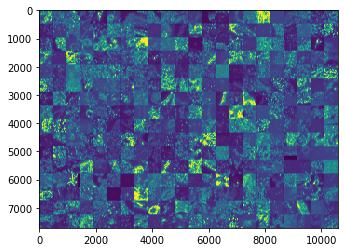

In [40]:
from matplotlib.patches import Rectangle
plt.imshow(plotExample)
# Get the current reference
ax = plt.gca()
imgIdx=0      
for p in range(progs.size):
    img_p_name=allImgNames[plottingIdx_i.astype(int)][progList[plottingIdx_i.astype(int)]==progs[p]]
    coord_p=coordlist[plottingIdx_i.astype(int)][progList[plottingIdx_i.astype(int)]==progs[p]]
    cluster_p=clusterRes[progList[plottingIdx_i.astype(int)]==progs[p]]
    for c in range(np.unique(cluster_p).size):
        clusteridx=np.arange(img_p_name.shape[0])[cluster_p==np.unique(cluster_p)[c]]
        np.random.seed(6)
        cp_plot=np.random.choice(clusteridx,min(ncells,clusteridx.size),replace=False)
        for cp_i in range(cp_plot.size):
            rowIdx=int(np.floor(imgOrder[imgIdx]/ncol))
            colIdx=imgOrder[imgIdx]%ncol
            img_p_split=img_p_name[cp_plot[cp_i]].split('_')
            coreID=img_p_split[-1]
            img_p_ID=img_p_name[cp_plot[cp_i]][:-len(coreID)-1] 
            coord_cp=coord_p[cp_plot[cp_i]]
            img_p=io.imread(os.path.join(datadir,img_p_ID,'zproject','dna',coreID+'.tif'))
            img_p=img_p[int(coord_cp[0]-radius_patch):int(coord_cp[0]+radius_patch),int(coord_cp[1]-radius_patch):int(coord_cp[1]+radius_patch)]
            rect = Rectangle((int(rowIdx*(radius_patch*2+2)+img_p.shape[0]/2-radius),int(colIdx*(radius_patch*2+2)+img_p.shape[1]/2-radius)),radius*2,radius*2,linewidth=0.1,edgecolor='r',facecolor='none')

            # Add the patch to the Axes
            ax.add_patch(rect)
            
            imgIdx+=1
plt.savefig(os.path.join(clusterplotsavepath,'plotexamples_patch_forAnnotation_withBoxes.jpg'),dpi=3000)

In [11]:
clusterplotsavepath='/media/xinyi/dcis2idc1/plots/cnnvaeexp0/cluster_reordered/minibatchkmean_ncluster8n_pcs50epoch311_plottingIdx_progBalanced_0_reordered_plots'

In [17]:
patchAnno=pd.read_csv(os.path.join(clusterplotsavepath,'nuclearGradeAssigned.csv'),header=None,dtype='str')

In [18]:
patchAnno

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,NaN,2,1,NaN,1,1,NaN,1,3,3,...,2,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,2,2,1,3,NaN,1,NO,NO,...,1,1,NO,1,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1,2,2,1,NaN,2,1,2,1,...,NaN,NaN,3,NO,NaN,NaN,NaN,NaN,NaN,NaN
3,1,NO,2,1,NO,1,2,3,1,1,...,1,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN
4,2,2,1,3,2,NaN,2,2,3,1,...,3,2,1,1,NaN,NaN,NaN,NaN,NaN,NaN
5,1,3,3,2,2,NaN,NO,2,2,2,...,1,NO,NO,1,NaN,NaN,NaN,NaN,NaN,NaN
6,1,1,1,NaN,2,3,3,2,2,1,...,NaN,NaN,1,2,NaN,NaN,NaN,NaN,NaN,NaN
7,3,1,1,2,3,1,NaN,NaN,2,2,...,1,1,NO,2,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,1,NaN,1,1,NO,3,1,2,NaN,...,2,NO,2,1,NaN,NaN,NaN,NaN,NaN,NaN
9,2,1,2,3,3,1,2,1,NO,NaN,...,2,1,2,2,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
patchProg=pd.read_csv(os.path.join(clusterplotsavepath,'plotexamples_trueProg_patch.csv'),header=None)
patchCluster=pd.read_csv(os.path.join(clusterplotsavepath,'plotexamples_trueClusters_patch.csv'),header=None)

In [20]:
compCluster=np.zeros((np.unique(patchCluster).size,3))
for c in np.unique(patchCluster):
    compCluster[c,0]=np.sum(patchAnno.to_numpy()[patchCluster.to_numpy()==c]=='1')
    compCluster[c,1]=np.sum(patchAnno.to_numpy()[patchCluster.to_numpy()==c]=='2')
    compCluster[c,2]=np.sum(patchAnno.to_numpy()[patchCluster.to_numpy()==c]=='3')

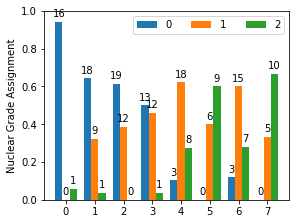

In [21]:
compCluster_norm=compCluster/np.sum(compCluster,axis=1,keepdims=True)

x = np.arange(compCluster.shape[0])  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained',figsize=(4,3))

for g in range(3):
    offset = width * multiplier
    rects = ax.bar(x + offset, compCluster_norm[:,g], width, label=g)
    ax.bar_label(rects,compCluster[:,g].astype(int), padding=3,fmt='%i')
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Nuclear Grade Assignment')
ax.set_xticks(x + width, np.arange(8))
ax.legend(loc='upper right', ncol=3)
ax.set_ylim(0, 1)
plt.savefig(os.path.join(clusterplotsavepath,'nuclearGrade2Cluster.pdf'))
plt.show()

In [24]:
nontumor=['Breast tissue','Atypical hyperplasia','Cancer adjacent normal breast ti','Hyperplasia','Invasive ductal carcinoma (breas']
dcis=['DCIS','DCIS and breast tissue','DCIS with early infiltration','Micropapillary DCIS with early i']
invasive=['Invasive ductal carcinoma','Invasive ductal carcinoma and br']
compProg=np.zeros((3,3))
for c in np.unique(patchProg):
    if c in nontumor:
        compProg[0,0]+=np.sum(patchAnno.to_numpy()[patchProg.to_numpy()==c]=='1')
        compProg[0,1]+=np.sum(patchAnno.to_numpy()[patchProg.to_numpy()==c]=='2')
        compProg[0,2]+=np.sum(patchAnno.to_numpy()[patchProg.to_numpy()==c]=='3')
    if c in dcis:
        compProg[1,0]+=np.sum(patchAnno.to_numpy()[patchProg.to_numpy()==c]=='1')
        compProg[1,1]+=np.sum(patchAnno.to_numpy()[patchProg.to_numpy()==c]=='2')
        compProg[1,2]+=np.sum(patchAnno.to_numpy()[patchProg.to_numpy()==c]=='3')
    if c in invasive:
        compProg[2,0]+=np.sum(patchAnno.to_numpy()[patchProg.to_numpy()==c]=='1')
        compProg[2,1]+=np.sum(patchAnno.to_numpy()[patchProg.to_numpy()==c]=='2')
        compProg[2,2]+=np.sum(patchAnno.to_numpy()[patchProg.to_numpy()==c]=='3')

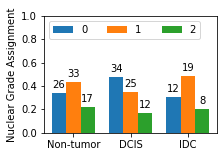

In [25]:
compProg_norm=compProg/np.sum(compProg,axis=1,keepdims=True)

x = np.arange(compProg.shape[0])  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained',figsize=(3,2))

for g in range(3):
    offset = width * multiplier
    rects = ax.bar(x + offset, compProg_norm[:,g], width, label=g)
    ax.bar_label(rects,compProg.astype(int)[:,g], padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Nuclear Grade Assignment')
ax.set_xticks(x + width, ['Non-tumor','DCIS','IDC'])
ax.legend(loc='upper left', ncol=3)
ax.set_ylim(0, 1)
plt.savefig(os.path.join(clusterplotsavepath,'nuclearGrade2Prog.pdf'))
plt.show()

In [36]:
patchAnnoNP=patchAnno.to_numpy()[:,:16].astype(str)
patchAnnoNP

array([['nan', '2', '1', 'nan', '1', '1', 'nan', '1', '3', '3', '3', '1',
        '2', 'nan', 'nan', '1'],
       ['1', '1', '2', '2', '1', '3', 'nan', '1', 'NO', 'NO', 'NO', '1',
        '1', '1', 'NO', '1'],
       ['2', '1', '2', '2', '1', 'nan', '2', '1', '2', '1', '3', 'nan',
        'nan', 'nan', '3', 'NO'],
       ['1', 'NO', '2', '1', 'NO', '1', '2', '3', '1', '1', '2', '2',
        '1', 'nan', 'nan', '2'],
       ['2', '2', '1', '3', '2', 'nan', '2', '2', '3', '1', 'NO', '3',
        '3', '2', '1', '1'],
       ['1', '3', '3', '2', '2', 'nan', 'NO', '2', '2', '2', '3', '3',
        '1', 'NO', 'NO', '1'],
       ['1', '1', '1', 'nan', '2', '3', '3', '2', '2', '1', '1', 'nan',
        'nan', 'nan', '1', '2'],
       ['3', '1', '1', '2', '3', '1', 'nan', 'nan', '2', '2', '2', 'nan',
        '1', '1', 'NO', '2'],
       ['nan', '1', 'nan', '1', '1', 'NO', '3', '1', '2', 'nan', 'NO',
        '1', '2', 'NO', '2', '1'],
       ['2', '1', '2', '3', '3', '1', '2', '1', 'NO', 'nan', '3'

In [61]:
patchCluster_withAnno=np.copy(patchCluster.to_numpy()[:,:16])
naCluster=np.zeros(np.unique(patchCluster_withAnno).size)
for c in np.unique(patchCluster_withAnno):
    naCluster[c]=np.sum(patchAnnoNP[patchCluster_withAnno==c]=='NO')
    naCluster[c]+=np.sum(patchAnnoNP[patchCluster_withAnno==c]=='nan')

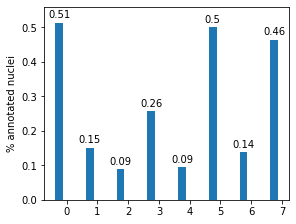

In [69]:
clusterCounts=np.zeros(8)
for c in np.unique(patchCluster_withAnno):
    clusterCounts[c]=np.sum(patchCluster_withAnno==c)
    
naCluster_norm=naCluster/clusterCounts

x = np.arange(naCluster.shape[0])  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(layout='constrained',figsize=(4,3))

rects = ax.bar(x , naCluster_norm, width)
ax.bar_label(rects,np.round(naCluster_norm,decimals=2), padding=3,fmt='%i')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('% annotated nuclei')
ax.set_xticks(x + width, np.arange(8))
# ax.legend(loc='upper right', ncol=2)
ax.set_ylim(0, 0.56)
plt.savefig(os.path.join(clusterplotsavepath,'nuclearGrade2Cluster_NAs.pdf'))
plt.show()

In [44]:
clusterCounts

array([35., 33., 34., 35., 32., 30., 29., 28.])

In [63]:
patchProg_withAnno=np.copy(patchProg.to_numpy()[:,:16])
nontumor=['Breast tissue','Atypical hyperplasia','Cancer adjacent normal breast ti','Hyperplasia','Invasive ductal carcinoma (breas']
dcis=['DCIS','DCIS and breast tissue','DCIS with early infiltration','Micropapillary DCIS with early i']
invasive=['Invasive ductal carcinoma','Invasive ductal carcinoma and br']
naProg=np.zeros(3)
for c in np.unique(patchProg):
    if c in nontumor:
        naProg[0]+=np.sum(patchAnnoNP[patchProg_withAnno==c]=='NO')
        naProg[0]+=np.sum(patchAnnoNP[patchProg_withAnno==c]=='nan')
    if c in dcis:
        naProg[1]+=np.sum(patchAnnoNP[patchProg_withAnno==c]=='NO')
        naProg[1]+=np.sum(patchAnnoNP[patchProg_withAnno==c]=='nan')
    if c in invasive:
        naProg[2]+=np.sum(patchAnnoNP[patchProg_withAnno==c]=='NO')
        naProg[2]+=np.sum(patchAnnoNP[patchProg_withAnno==c]=='nan')


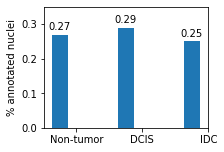

In [70]:
progCounts=np.zeros(3)
for c in np.unique(patchProg_withAnno):
    if c in nontumor:
        progCounts[0]+=np.sum(patchProg_withAnno==c)
    if c in dcis:
        progCounts[1]+=np.sum(patchProg_withAnno==c)
    if c in invasive:
        progCounts[2]+=np.sum(patchProg_withAnno==c)

naProg_norm=naProg/progCounts
x = np.arange(naProg.shape[0])  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(layout='constrained',figsize=(3,2))

rects = ax.bar(x , naProg_norm, width)
ax.bar_label(rects,np.round(naProg_norm,decimals=2), padding=3)
multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('% annotated nuclei')
ax.set_xticks(x + width, ['Non-tumor','DCIS','IDC'])
# ax.legend(loc='upper left', ncol=3)
ax.set_ylim(0, 0.35)
# plt.tight_layout()
plt.savefig(os.path.join(clusterplotsavepath,'nuclearGrade2Prog_NAs.pdf'))
plt.show()

## staging: claudio vs biomax

In [72]:
stageAnno=pd.read_csv(os.path.join(clusterplotsavepath,'stageAnnotation.csv'),index_col=0)

In [73]:
stageAnno[np.logical_not(np.isfinite(stageAnno))]=0
stageAnno=stageAnno.iloc[:,:9]

In [74]:
stageAnno

,Non-tumoral breast tissue,Hyperplasia,Atypical hyperplasia,DCIS and breast tissue,DCIS,DCIS with microinvasion and breast tissue,DCIS with microinvasion,DCIS+IDC,IDC
Breast tissue,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Cancer adjacent breast tissue,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
IDC (breast tissue),0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Hyperplasia,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Atypical hyperplasia,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0
DCIS and breast tissue,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0
DCIS,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
DCIS with early infiltration,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
Micropapilary DCIS with early infiltration,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
IDC and breast tissue,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0


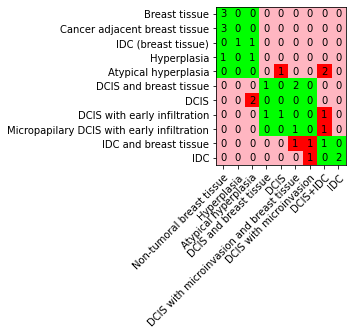

In [78]:
stagingBg=np.zeros((stageAnno.shape[0],stageAnno.shape[1],3))
stagingBg[:5,:3,1]=1
stagingBg[:5,3:,0]=1
stagingBg[:5,3:,1]=182/255
stagingBg[:5,3:,2]=193/255

stagingBg[5:9,3:7,1]=1
stagingBg[5:9,:3,0]=1
stagingBg[5:9,:3,1]=182/255
stagingBg[5:9,:3,2]=193/255
stagingBg[5:9,7:,0]=1
stagingBg[5:9,7:,1]=182/255
stagingBg[5:9,7:,2]=193/255

stagingBg[9:,7:,1]=1
stagingBg[9:,:7,0]=1
stagingBg[9:,:7,1]=182/255
stagingBg[9:,:7,2]=193/255

stagingBg[:5,3:][stageAnno.to_numpy()[:5,3:]>0]=[1,0,0]
stagingBg[5:9,:3][stageAnno.to_numpy()[5:9,:3]>0]=[1,0,0]
stagingBg[5:9,7:][stageAnno.to_numpy()[5:9,7:]>0]=[1,0,0]
stagingBg[9:,:7][stageAnno.to_numpy()[9:,:7]>0]=[1,0,0]

fig, ax = plt.subplots(figsize=(5,7))
im = ax.imshow(stagingBg)
ax.set_xticks(np.arange(stagingBg.shape[1]), labels=stageAnno.columns)
ax.set_yticks(np.arange(stagingBg.shape[0]), labels=stageAnno.index)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
for i in range(stagingBg.shape[0]):
    for j in range(stagingBg.shape[1]):
        text = ax.text(j, i, int(stageAnno.iloc[i, j]),
                       ha="center", va="center", color="black")

fig.tight_layout()
plt.savefig(os.path.join(clusterplotsavepath,'staging.pdf'))
plt.show()

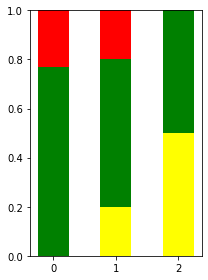

In [75]:
stageAnnoNP=stageAnno.to_numpy()
stageCounts=np.zeros(3)
stageCounts[0]=np.sum(stageAnnoNP[:5])
stageCounts[1]=np.sum(stageAnnoNP[5:9])
stageCounts[2]=np.sum(stageAnnoNP[9:])
fig, ax = plt.subplots(figsize=(3,4))
bottom=np.zeros(3)
lessProg=np.zeros(3)
lessProg[1]=np.sum(stageAnnoNP[5:9,:3])
lessProg[2]=np.sum(stageAnnoNP[9:,:7])
lessProg=lessProg/stageCounts
ax.bar(np.arange(3),lessProg,bottom=bottom,color='yellow',width=0.5)
bottom+=lessProg

correctProg=np.zeros(3)
correctProg[0]=np.sum(stageAnnoNP[:5,:3])
correctProg[1]=np.sum(stageAnnoNP[5:9,3:7])
correctProg[2]=np.sum(stageAnnoNP[9:,7:])
correctProg=correctProg/stageCounts
ax.bar(np.arange(3),correctProg,bottom=bottom,color='green',width=0.5)
bottom+=correctProg

moreProg=np.zeros(3)
moreProg[0]=np.sum(stageAnnoNP[:5,3:])
moreProg[1]=np.sum(stageAnnoNP[5:9,7:])
moreProg=moreProg/stageCounts
ax.bar(np.arange(3),moreProg,bottom=bottom,color='red',width=0.5)

plt.tight_layout()
plt.savefig(os.path.join(clusterplotsavepath,'stagingBar.pdf'))
plt.show()

## neighbor cluster ID

In [15]:
from sklearn.metrics import pairwise_distances

### distance threshold

In [22]:
# maxncell=130000

neighborhoodSize=16*9
#neighborhoodSize=16*9*1.5 #run later
for ncluster in [8]:
    savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+plotsavenameAdd
    with open(os.path.join(clustersavedir_old,savenamecluster), 'rb') as output:
        clusterRes=pickle.load(output)
    clusterplotsavepath=os.path.join(clustersavedir,savenamecluster+'_plots')
    if not os.path.exists(clusterplotsavepath):
        os.mkdir(clusterplotsavepath)
    progs=np.unique(progList[plottingIdx_i.astype(int)])
    for p in range(progs.size):
        print(p)
        coord_p=coordlist[plottingIdx_i.astype(int)][progList[plottingIdx_i.astype(int)]==progs[p]]
        cluster_p=clusterRes[progList[plottingIdx_i.astype(int)]==progs[p]]
        imgNames_p=allImgNames[plottingIdx_i.astype(int)][progList[plottingIdx_i.astype(int)]==progs[p]]
        
        selfp=np.array([])
        neighborp=np.array([])
        for imgN in np.unique(imgNames_p):
            print(imgN)
#         subsampleIdx=np.arange(coord_p.shape[0])
#         if coord_p.shape[0]>maxncell:
#             np.random.seed(6)
#             subsampleIdx=np.random.choice(subsampleIdx,maxncell,replace=False)
        
            neighbors=np.tile(cluster_p[imgNames_p==imgN],(np.sum(imgNames_p==imgN),1))
            selfs=np.tile(cluster_p[imgNames_p==imgN].reshape((-1,1)),(1,np.sum(imgNames_p==imgN)))
            dist=pairwise_distances(coord_p[imgNames_p==imgN],n_jobs=-1)
            distIn=np.logical_and(dist<neighborhoodSize,dist>0)
            selfp=np.concatenate((selfp,selfs[distIn]))
            neighborp=np.concatenate((neighborp,neighbors[distIn]))
            
        plotCTcomp_hist(selfp,neighborp,clusterplotsavepath,'neighborHist'+progs[p],False)
        gc.collect()

0
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C1
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C3
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C4
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C5
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C6
br1003a_3_collagen1_647_hoechst_C1
br1003a_3_collagen1_647_hoechst_C3
br1003a_3_collagen1_647_hoechst_C4
br1003a_3_collagen1_647_hoechst_C5
br1003a_3_collagen1_647_hoechst_C6
br1003a_4_cytokeratin_555_gh2ax_647_hoechst_C1
br1003a_4_cytokeratin_555_gh2ax_647_hoechst_C4
br1003a_4_cytokeratin_555_gh2ax_647_hoechst_C5
br1003a_4_cytokeratin_555_gh2ax_647_hoechst_C6
1
br1003a_1_cytokeratin_555_aSMA_647_hoechst_I1
br1003a_1_cytokeratin_555_aSMA_647_hoechst_I10
br1003a_1_cytokeratin_555_aSMA_647_hoechst_I2
br1003a_1_cytokeratin_555_aSMA_647_hoechst_I3
br1003a_1_cytokeratin_555_aSMA_647_hoechst_I7
br1003a_1_cytokeratin_555_aSMA_647_hoechst_I8
br1003a_1_cytokeratin_555_aSMA_647_hoechst_I9
br1003a_3_collagen1_647_hoechst_I1
br1003a_3_collagen1_647_hoechst_I10
br1003a_3

br8018a_4_cytokeratin_555_gh2ax_647_hoechst_F4
br8018a_4_cytokeratin_555_gh2ax_647_hoechst_F7
br8018a_4_cytokeratin_555_gh2ax_647_hoechst_F8
8
br8018a_1_cytokeratin_555_aSMA_647_hoechst_B6
br8018a_3_collagen1_647_hoechst_B6
br8018a_4_cytokeratin_555_gh2ax_647_hoechst_B6
9
br301_4_cytokeratin_555_aSMA_647_hoechst_B5
br301_4_cytokeratin_555_aSMA_647_hoechst_B6
br301_4_cytokeratin_555_aSMA_647_hoechst_D3
br301_4_cytokeratin_555_aSMA_647_hoechst_E3
br301_6_collagen1_647_hoechst_B5
br301_6_collagen1_647_hoechst_B6
br301_6_collagen1_647_hoechst_D3
br301_6_collagen1_647_hoechst_E3
10
br301_4_cytokeratin_555_aSMA_647_hoechst_C3
br301_4_cytokeratin_555_aSMA_647_hoechst_C4
br301_6_collagen1_647_hoechst_C3
br301_6_collagen1_647_hoechst_C4


#### random samples

In [17]:
#separate comparisons of each core with its random assignments

#cluster labels in each sample are randomly reordered

nRandomsamplesTotal=40000 #for bonferroni
ngroups=80

neighborhoodSize=16*9
ncluster=8
savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+plotsavenameAdd
with open(os.path.join(clustersavedir_old,savenamecluster), 'rb') as output:
    clusterRes=pickle.load(output)
clusterplotsavepath=os.path.join(clustersavedir,savenamecluster+'_plots')
if not os.path.exists(clusterplotsavepath):
    os.mkdir(clusterplotsavepath)
neighborplotsavepath=os.path.join(clusterplotsavepath,'neighborHist_withRandom_nsamples'+str(nRandomsamplesTotal))
if not os.path.exists(neighborplotsavepath):
    os.mkdir(neighborplotsavepath)
progs=np.unique(progList[plottingIdx_i.astype(int)])

for p in range(progs.size)
    print(p)
    coord_p=coordlist[plottingIdx_i.astype(int)][progList[plottingIdx_i.astype(int)]==progs[p]]
    cluster_p=clusterRes[progList[plottingIdx_i.astype(int)]==progs[p]]
    imgNames_p=allImgNames[plottingIdx_i.astype(int)][progList[plottingIdx_i.astype(int)]==progs[p]]

    selfp=np.array([])
    neighborp=np.array([])
    selfp_random=[None]*np.unique(imgNames_p).size
    neighborp_random=[None]*np.unique(imgNames_p).size
#     nRandomsamplesTotal=np.ceil(nRandomsamplesTotal_perProg/np.unique(imgNames_p).size).astype(int)
    nRandomsamples=np.ceil(nRandomsamplesTotal/ngroups).astype(int)
    nRandomsamplesTotal=nRandomsamples*ngroups
    actualSamples=nRandomsamples*ngroups*np.unique(imgNames_p).size
    
    resRandom_sum=np.zeros((ncluster,ncluster))
    greaterCount=np.zeros((ncluster,ncluster))
    for imgNidx in range(np.unique(imgNames_p).size):
        imgN=np.unique(imgNames_p)[imgNidx]
        print(imgN)
        nsamples=np.sum(imgNames_p==imgN)
        cluster_ps=cluster_p[imgNames_p==imgN]
        neighbors=np.tile(cluster_ps,(nsamples,1))
        selfs=np.tile(cluster_ps.reshape((-1,1)),(1,nsamples))

        dist=pairwise_distances(coord_p[imgNames_p==imgN],n_jobs=-1)
        distIn=np.logical_and(dist<neighborhoodSize,dist>0)
        selfp=np.concatenate((selfp,selfs[distIn]))
        neighborp=np.concatenate((neighborp,neighbors[distIn]))
        np.random.seed(6)
        
        res_curr=getHistMatrix_clusters(selfs[distIn],neighbors[distIn])
        
#         selfp_random_s=np.ones((nRandomsamplesTotal,np.sum(distIn)))
#         neighborp_random_s=np.ones((nRandomsamplesTotal,np.sum(distIn)))
        resRandom=np.zeros((nRandomsamplesTotal,ncluster,ncluster))
        randAll=0
        for ng in range(ngroups):
            print(ng)
            
            orderj=np.random.rand(nRandomsamples,nsamples).argsort(axis=-1)
            print('sampled')
            cluster_psCopied=np.tile(cluster_ps,(nRandomsamples,1))
            selfp_random_sn=np.tile(cluster_psCopied[np.arange(nRandomsamples)[:,None],orderj].reshape(nRandomsamples,nsamples,1),(1,1,nsamples))[np.tile(distIn,(nRandomsamples,1,1))]
            neighborp_random_sn=np.tile(cluster_psCopied[np.arange(nRandomsamples)[:,None],orderj].reshape(nRandomsamples,1,nsamples),(1,nsamples,1))[np.tile(distIn,(nRandomsamples,1,1))]
            selfp_random_s=selfp_random_sn.reshape(nRandomsamples,np.sum(distIn))
            neighborp_random_s=neighborp_random_sn.reshape(nRandomsamples,np.sum(distIn))
            for rand in range(nRandomsamples):
                resRandom[randAll]=getHistMatrix_clusters(selfp_random_s[rand],neighborp_random_s[rand])
                randAll+=1
            gc.collect()
#             selfp_random_s=np.zeros((nRandomsamples,np.sum(distIn)))
#             neighborp_random_s=np.zeros((nRandomsamples,np.sum(distIn)))
#             for j in range(nRandomsamples):
#                 print(j)
# #                 orderj=np.random.choice(nsamples,nsamples,replace=False)
#                 selfp_random_s[j]=np.tile(cluster_ps[orderj[j]].reshape((-1,1)),(1,nsamples))[distIn]
#                 neighborp_random_s[j]=np.tile(cluster_ps[orderj[j]],(nsamples,1))[distIn]

#                 if selfp_random_s is None:
#                     selfp_random_s=selfp_random_sj
#                     neighborp_random_s=neighborp_random_sj
#                 else:
#                     selfp_random_s=np.vstack((selfp_random_s,selfp_random_sj))
#                     neighborp_random_s=np.vstack((neighborp_random_s,neighborp_random_sj))
        
    
        
        
        resRandomMean=np.mean(resRandom,axis=0,keepdims=True)
    
        distRand=np.abs(resRandom-resRandomMean)
        distTrue=np.abs(res_curr-resRandomMean[0]).reshape((1,ncluster,ncluster))
        distCompare=np.greater(distRand,distTrue)
        greaterCount=greaterCount+np.sum(distCompare,axis=0)+1
    
        resRandom_sum=resRandom_sum+np.sum(resRandom,axis=0)
    res=getHistMatrix(selfp,neighborp)
    #save simulation results
    np.savetxt(os.path.join(neighborplotsavepath,'neighborHist_withRandom'+progs[p]+'_significanceSeparated.csv'),greaterCount/(actualSamples+1))
    np.savetxt(os.path.join(neighborplotsavepath,'neighborHist_withRandom'+progs[p]+'randMean.csv'),resRandom_sum/actualSamples)
    np.savetxt(os.path.join(neighborplotsavepath,'neighborHist_withRandom'+progs[p]+'res.csv'),res)

    
    gc.collect()

8
br8018a_1_cytokeratin_555_aSMA_647_hoechst_B6
0
sampled
1
sampled
2
sampled
3
sampled
4
sampled
5
sampled
6
sampled
7
sampled
8
sampled
9
sampled
10
sampled
11
sampled
12
sampled
13
sampled
14
sampled
15
sampled
16
sampled
17
sampled
18
sampled
19
sampled
20
sampled
21
sampled
22
sampled
23
sampled
24
sampled
25
sampled
26
sampled
27
sampled
28
sampled
29
sampled
30
sampled
31
sampled
32
sampled
33
sampled
34
sampled
35
sampled
36
sampled
37
sampled
38
sampled
39
sampled
40
sampled
41
42
sampled
43
sampled
44
sampled
45
sampled
46
sampled
47
sampled
48
sampled
49
sampled
50
sampled
51
sampled
52
sampled
53
sampled
54
sampled
55
sampled
56
sampled
57
sampled
58
sampled
59
sampled
60
sampled
61
sampled
62
sampled
63
sampled
64
sampled
65
sampled
66
sampled
67
sampled
68
sampled
69
sampled
70
sampled
71
sampled
72
sampled
73
sampled
74
sampled
75
sampled
76
sampled
77
sampled
78
sampled
79
sampled
br8018a_3_collagen1_647_hoechst_B6
0
sampled
1
sampled
2
sampled
3
sampled
4
sampled
5
sam